This notebook assumes we have 2 users top spotify data, and experiments with how we can compare them, and utilize them to build a new playlist.

First we grab our SpotifyAPI class, so when we need to make API calls, we can

In [1]:
import base64
import datetime
from urllib.parse import urlencode

import requests

#Follows Spotify's "Implicit Grant" Authorization flow
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    authorization_url = "https://accounts.spotify.com/authorize"
    
    #external functions ("public")
    

    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')

    def get_playlist_tracks(self, _id):
        return self.get_resource(_id, resource_type='playlists', addendum='tracks')

    def get_track_features(self, _id):
        return self.get_resource(_id, resource_type='audio-features')

    def get_track_analysis(self, _id):
      return self.get_resource(_id, resource_type='audio-analysis') 

    def search(self, query=None, operator=None, operator_query=None, search_type='artist', limit=20 ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": str(limit)})
        return self.base_search(query_params)

    #generic api request, accepts the full endpoint string

    def generic_get(self, endpoint):
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            if r.status_code == 429:
              print('Retry after ' + str(r.headers['Retry-After']) + ' seconds')
              raise Exception("You are requesting too much data, retry after " + str(r.headers['Retry-After']) + ' seconds')
            return {}
        return r.json()

    def generic_post(self, endpoint):
        headers = self.get_resource_header()
        r = requests.post(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def generic_put(self, endpoint):
        headers = self.get_resource_header()
        r = requests.put(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)

            
    #internal functions ("private")


    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1', addendum=''):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/{addendum}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()

    #new functions for user functions

    def get_current_user(self):
        endpoint = f"https://api.spotify.com/v1/me"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_recently_played(self):
        endpoint = f"https://api.spotify.com/v1/me/player/recently-played"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_top(self, top_type='tracks', time_range='medium_term'):
        #endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?limit=50&time_range{time_range}"
        endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?time_range={time_range}&limit=50"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def get_user(self, user):
        endpoint = f"https://api.spotify.com/v1/users/{user}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

import webbrowser
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time

#Initializing spotify API and defining some important constants
client_id = ""
client_secret = ""

spotify = SpotifyAPI(client_id, client_secret)
indices = {'resource_types':['tracks','artists'],'time_frames':['short_term','medium_term', 'long_term']}



Now some other initializations that we have covered in previous notebooks.

Now for the good stuff. We load in each user's data (Use GetUserData notebook to pull this for each user)

In [2]:
#Uploading json files containing user data
from google.colab import files
uploaded = files.upload()

Saving kyle.sellers (2).json to kyle.sellers (2).json
Saving phillwill16.json to phillwill16.json


# New Section

In [3]:
!ls

'kyle.sellers (2).json'   phillwill16.json   sample_data


place the name of the .json files for both users below.

In [4]:
#get all user data raw from json files
user_1_file_name = ''
user_2_file_name = ''

def getUserTopDataFromJson(file_name):
  with open(file_name) as json_file:
    return json.load(json_file)

user_1_data = getUserTopDataFromJson(user_1_file_name)
user_2_data = getUserTopDataFromJson(user_2_file_name)

print(user_1_data)
print(user_2_data)


def addRanks(user_data):
  for resource_type in indices['resource_types']:
    for time_frame in indices['time_frames']:
      rank = 0
      for resource in user_data[resource_type + '_' + time_frame]:
        rank += 1
        resource['rank'] = rank

addRanks(user_1_data)
addRanks(user_2_data)

for item in user_1_data['artists_long_term']:
  print(item)

for item in user_2_data['artists_long_term']:
  print(item)

#defining relative weights of time periods, as well as how the #1 is scaled relative to the last in each time period
short_term_weight = 0.3
medium_term_weight = 0.3
long_term_weight = 0.4

short_term_scaling = 3
medium_term_scaling = 3
long_term_scaling = 3

time_frame_weights_scalings = {
    'short_term': {'weight': short_term_weight,'scaling':short_term_scaling},
    'medium_term': {'weight': medium_term_weight,'scaling':medium_term_scaling},
    'long_term': {'weight': long_term_weight,'scaling':long_term_scaling}
}


def addWeights(user_data):
  for resource_type in indices['resource_types']:
    for time_frame in indices['time_frames']:
      scaling = time_frame_weights_scalings[time_frame]['scaling']
      rank = 0
      for resource in user_data[resource_type + '_' + time_frame]:
        amount_per_step = ((scaling-1)/scaling) / (len(user_data[resource_type + '_' + time_frame]) - 1)
        resource['weight'] = (1/scaling + ((len(user_data[resource_type + '_' + time_frame]) - (resource['rank'])) * amount_per_step)) * time_frame_weights_scalings[time_frame]['weight']

addWeights(user_1_data)
addWeights(user_2_data)

for item in user_1_data['artists_short_term']:
  print(item['name'] +' : ' + str(item['weight']))

for item in user_2_data['artists_short_term']:
  print(item['name'] +' : ' + str(item['weight']))

def getCombinedData(user_data):
  user_combined = {'artists': [], 'tracks': []}
  for resource_type in indices['resource_types']:
    combined_data = []
    for resource in user_data[resource_type + '_short_term']:
      combined_data.append(resource.copy())
    
    redundant_data = []
    for combined_resource in combined_data:
      for resource in user_data[resource_type + '_medium_term']:
        if combined_resource['id'] == resource['id']:
          combined_resource['weight'] += resource['weight']
          redundant_data.append(resource.copy())
    
    for resource in user_data[resource_type + '_medium_term']:
      to_add = True
      for redundant_resource in redundant_data:
        if resource['id'] == redundant_resource['id']:
          to_add = False
      if to_add:
        combined_data.append(resource.copy())
    

    redundant_data = []
    for combined_resource in combined_data:
      for resource in user_data[resource_type + '_long_term']:
        if combined_resource['id'] == resource['id']:
          combined_resource['weight'] += resource['weight']
          redundant_data.append(resource.copy())
    
    for resource in user_data[resource_type + '_long_term']:
      to_add = True
      for redundant_resource in redundant_data:
        if resource['id'] == redundant_resource['id']:
          to_add = False
      if to_add:
        combined_data.append(resource.copy())
    
    user_combined[resource_type] = combined_data
  return user_combined

user_1_combined = getCombinedData(user_1_data)
user_2_combined = getCombinedData(user_2_data)

  
for val in user_1_combined['artists']:
  name = val['name']
  weight = val['weight']
  print(f'{name} : {weight}')

# take second element for sort
def getWeight(resource):
    return resource['weight']

# sort list with key
user_1_combined['artists'].sort(key=getWeight, reverse=True)

for val in user_1_combined['artists']:
  name = val['name']
  weight = val['weight']
  print(f'{name} : {weight}')


def combine2UsersData(user_1_combined, user_2_combined):
  # will return aggregate, common, user_1_unique, and user_2_unique
  aggregate_data = {'artists': [], 'tracks': []}
  common_data = {'artists': [], 'tracks': []}
  user_1_unique_data = {'artists': [], 'tracks': []}
  user_2_unique_data = {'artists': [], 'tracks': []}


  for resource_type in indices['resource_types']:
    combined_data = []
    for resource in user_1_combined[resource_type]:
      combined_data.append(resource.copy())
    
    redundant_data = []
    for combined_resource in combined_data:
      for resource in user_2_combined[resource_type]:
        if combined_resource['id'] == resource['id']:
          combined_resource['weight'] += resource['weight']
          redundant_data.append(combined_resource.copy())
      
    user_2_data = []
    for resource in user_2_combined[resource_type]:
      to_add = True
      for redundant_resource in redundant_data:
        if resource['id'] == redundant_resource['id']:
          to_add = False
      if to_add:
        combined_data.append(resource.copy())
        user_2_data.append(resource.copy())
      
    user_1_data = []
    for resource in user_1_combined[resource_type]:
      to_add = True
      for redundant_resource in redundant_data:
        if resource['id'] == redundant_resource['id']:
          to_add = False
      if to_add:
        user_1_data.append(resource.copy())

    aggregate_data[resource_type] = combined_data
    common_data[resource_type] = redundant_data
    user_1_unique_data[resource_type] = user_1_data
    user_2_unique_data[resource_type] = user_2_data

  return aggregate_data, common_data, user_1_unique_data, user_2_unique_data


aggregate, common, user_1_unique, user_2_unique = combine2UsersData(user_1_combined, user_2_combined)

print(len(common['artists']))
for artist in common['artists']:
  print(artist['name'] + ' : ' + str(artist['weight']))

print('============================================')

print(len(aggregate['artists']))
for artist in aggregate['artists']:
  print(artist['name'] + ' : ' + str(artist['weight']))

print('============================================')

print(len(user_1_unique['artists']))
for artist in user_1_unique['artists']:
  print(artist['name'] + ' : ' + str(artist['weight']))

print('============================================')

print(len(user_2_unique['artists']))
for artist in user_2_unique['artists']:
  print(artist['name'] + ' : ' + str(artist['weight']))

print('============================================')


aggregate_artists = aggregate['artists']
common_artists = common['artists']
user_1_artists_unique = user_1_unique['artists']
user_2_artists_unique = user_2_unique['artists']

user_1_artists_unique_stripped = []
user_2_artists_unique_stripped = []
common_artists_stripped = []

for artist in user_1_artists_unique:
  user_1_artists_unique_stripped.append({'name': artist['name'], 'id': artist['id'], 'weight': artist['weight']})

for artist in user_2_artists_unique:
  user_2_artists_unique_stripped.append({'name': artist['name'], 'id': artist['id'], 'weight': artist['weight']})

for artist in common_artists:
  common_artists_stripped.append({'name': artist['name'], 'id': artist['id'], 'weight': artist['weight']})

for artist in user_1_artists_unique_stripped:
  print(artist)

print('\n=====================================================================\n')
for artist in user_2_artists_unique_stripped:
  print(artist)

print('\n=====================================================================\n')

for artist in common_artists_stripped:
  print(artist)

print('\n=====================================================================\n')

{'tracks_short_term': [{'album': {'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/36PWgrlKrQpL8vvRR2kURR'}, 'href': 'https://api.spotify.com/v1/artists/36PWgrlKrQpL8vvRR2kURR', 'id': '36PWgrlKrQpL8vvRR2kURR', 'name': 'Origami Button', 'type': 'artist', 'uri': 'spotify:artist:36PWgrlKrQpL8vvRR2kURR'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/5SjcJ9pVDkFI5swmlEiUWh'}, 'href': 'https://api.spotify.com/v1/albums/5SjcJ9pVDkFI5swmlEiU

In [5]:
count = 0
for artist in user_1_artists_unique_stripped:
  count +=1
  print(count)
  time.sleep(0.1)
  related_artist_ids = []
  similar_artists = spotify.generic_get('https://api.spotify.com/v1/artists/' + artist['id'] +'/related-artists')
  for similar_artist in similar_artists['artists']:
    related_artist_ids.append({'name':similar_artist['name'],'id':similar_artist['id']})
  artist['similar_artists'] = related_artist_ids

for artist in user_2_artists_unique_stripped:
  count +=1
  print(count)
  time.sleep(0.1)
  related_artist_ids = []
  similar_artists = spotify.generic_get('https://api.spotify.com/v1/artists/' + artist['id'] +'/related-artists')
  for similar_artist in similar_artists['artists']:
    related_artist_ids.append({'name':similar_artist['name'],'id':similar_artist['id']})
  artist['similar_artists'] = related_artist_ids

for artist in common_artists_stripped:
  count +=1
  print(count)
  time.sleep(0.1)
  related_artist_ids = []
  similar_artists = spotify.generic_get('https://api.spotify.com/v1/artists/' + artist['id'] +'/related-artists')
  for similar_artist in similar_artists['artists']:
    related_artist_ids.append({'name':similar_artist['name'],'id':similar_artist['id']})
  artist['similar_artists'] = related_artist_ids


#REPLACING ALL $ WITH S because graphing below doesn;t like it
for artist in user_1_artists_unique_stripped:
  artist['name'] = artist['name'].replace("$", "S")
  for sim_artist in artist['similar_artists']:
    sim_artist['name'] = sim_artist['name'].replace("$", "S")

for artist in user_2_artists_unique_stripped:
  artist['name'] = artist['name'].replace("$", "S")
  for sim_artist in artist['similar_artists']:
    sim_artist['name'] = sim_artist['name'].replace("$", "S")

for artist in common_artists_stripped:
  artist['name'] = artist['name'].replace("$", "S")
  for sim_artist in artist['similar_artists']:
    sim_artist['name'] = sim_artist['name'].replace("$", "S")


for artist in user_1_artists_unique_stripped:
  print(artist)

print('\n=====================================================================\n')
for artist in user_2_artists_unique_stripped:
  print(artist)

print('\n=====================================================================\n')

for artist in common_artists_stripped:
  print(artist)

print('\n=====================================================================\n')



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
{'name': 'Dance Gavin Dance', 'id': '6guC9FqvlVboSKTI77NG2k', 'weight': 0.9662821650399289, 'similar_artists': [{'name': 'Emarosa', 'id': '68tKVjVvcqUfKFFLr2j0Ek'}, {'name': 'Isles & Glaciers', 'id': '6dHr8Y0nPrnHiBOuJzuu8F'}, {'name': 'Chiodos', 'id': '4ZIBrskTJWmkJUvM7uAu1o'}, {'name': 'Scary Kids Scaring Kids', 'id': '3cdos5vq3wSUR8mEvMiqq9'}, {'name': 'Jonny Craig', 'id': '46MmlFKM8ivDsUnGOejvSM'}, {'name': 'Underoath', 'id': '3GzWhE2xadJiW8MqR

['4O15NlyKLIASxsJ0PrXPfz', '5K4W6rqBFWDnAN6FQUkS6x', '1t20wYnTiAT0Bs7H1hv9Wt', '2qxJFvFYMEDqd7ui6kSAcq', '3mIj9lX2MWuHmhNCA7LSCW', '5JZ7CnR6gTvEMKX4g70Amv', '23fqKkggKUBHNkbKtXEls4', '7CajNmpbOovFoOoasH2HaY', '4MCBfE4596Uoi2O4DtmEMz', '6guC9FqvlVboSKTI77NG2k', '0tko2stnUOqejIto8rKRh7', '05MlomiA9La0OiNIAGqECk', '2LkMP01m9PIf5r87iC0HI2', '36PWgrlKrQpL8vvRR2kURR', '2JFljHPanIjYy2QqfNYvC0', '5TUa95aB5Vu2CzwCnZd6t0', '7DwHQdzAPFLx6Gug80MjU1', '1HIPy5eD1xnDTSKjIzzlcU', '0xpJGyjbEzkWSNfcf2tcMl', '2n2RSaZqBuUUukhbLlpnE6', '3dz0NnIZhtKKeXZxLOxCam', '4V8LLVI7PbaPR0K2TGSxFF', '3z8aGzEIL6yA1mFXNFf9E3', '6nxWCVXbOlEVRexSbLsTer', '4vGrte8FDu062Ntj0RsPiZ', '4tZwfgrHOc3mvqYlEYSvVi', '7DHLWUbPofoFR1yRFfgL5a', '1FVOt1XlpnaCueBolWF92k', '1RdlYzlj42Mq7tO5y1o4Cz', '1ZlNyL0lpTRXyotxiHvgCl', '4RxUGW2HRMIm9qI1GJqMgK', '57jIhbre5LNTiR4Pr60wUs', '46iJ1VD4HKFnqjISGqlZkV', '6VD4UEUPvtsemqD3mmTqCR', '1dtiGEl2aljrMiP2QqqoZZ', '55Aa2cqylxrFIXC767Z865', '50JJSqHUf2RQ9xsHs0KMHg', '0szWPxzzE8DVEfXFRCLBUb', '6d4jrmreCm

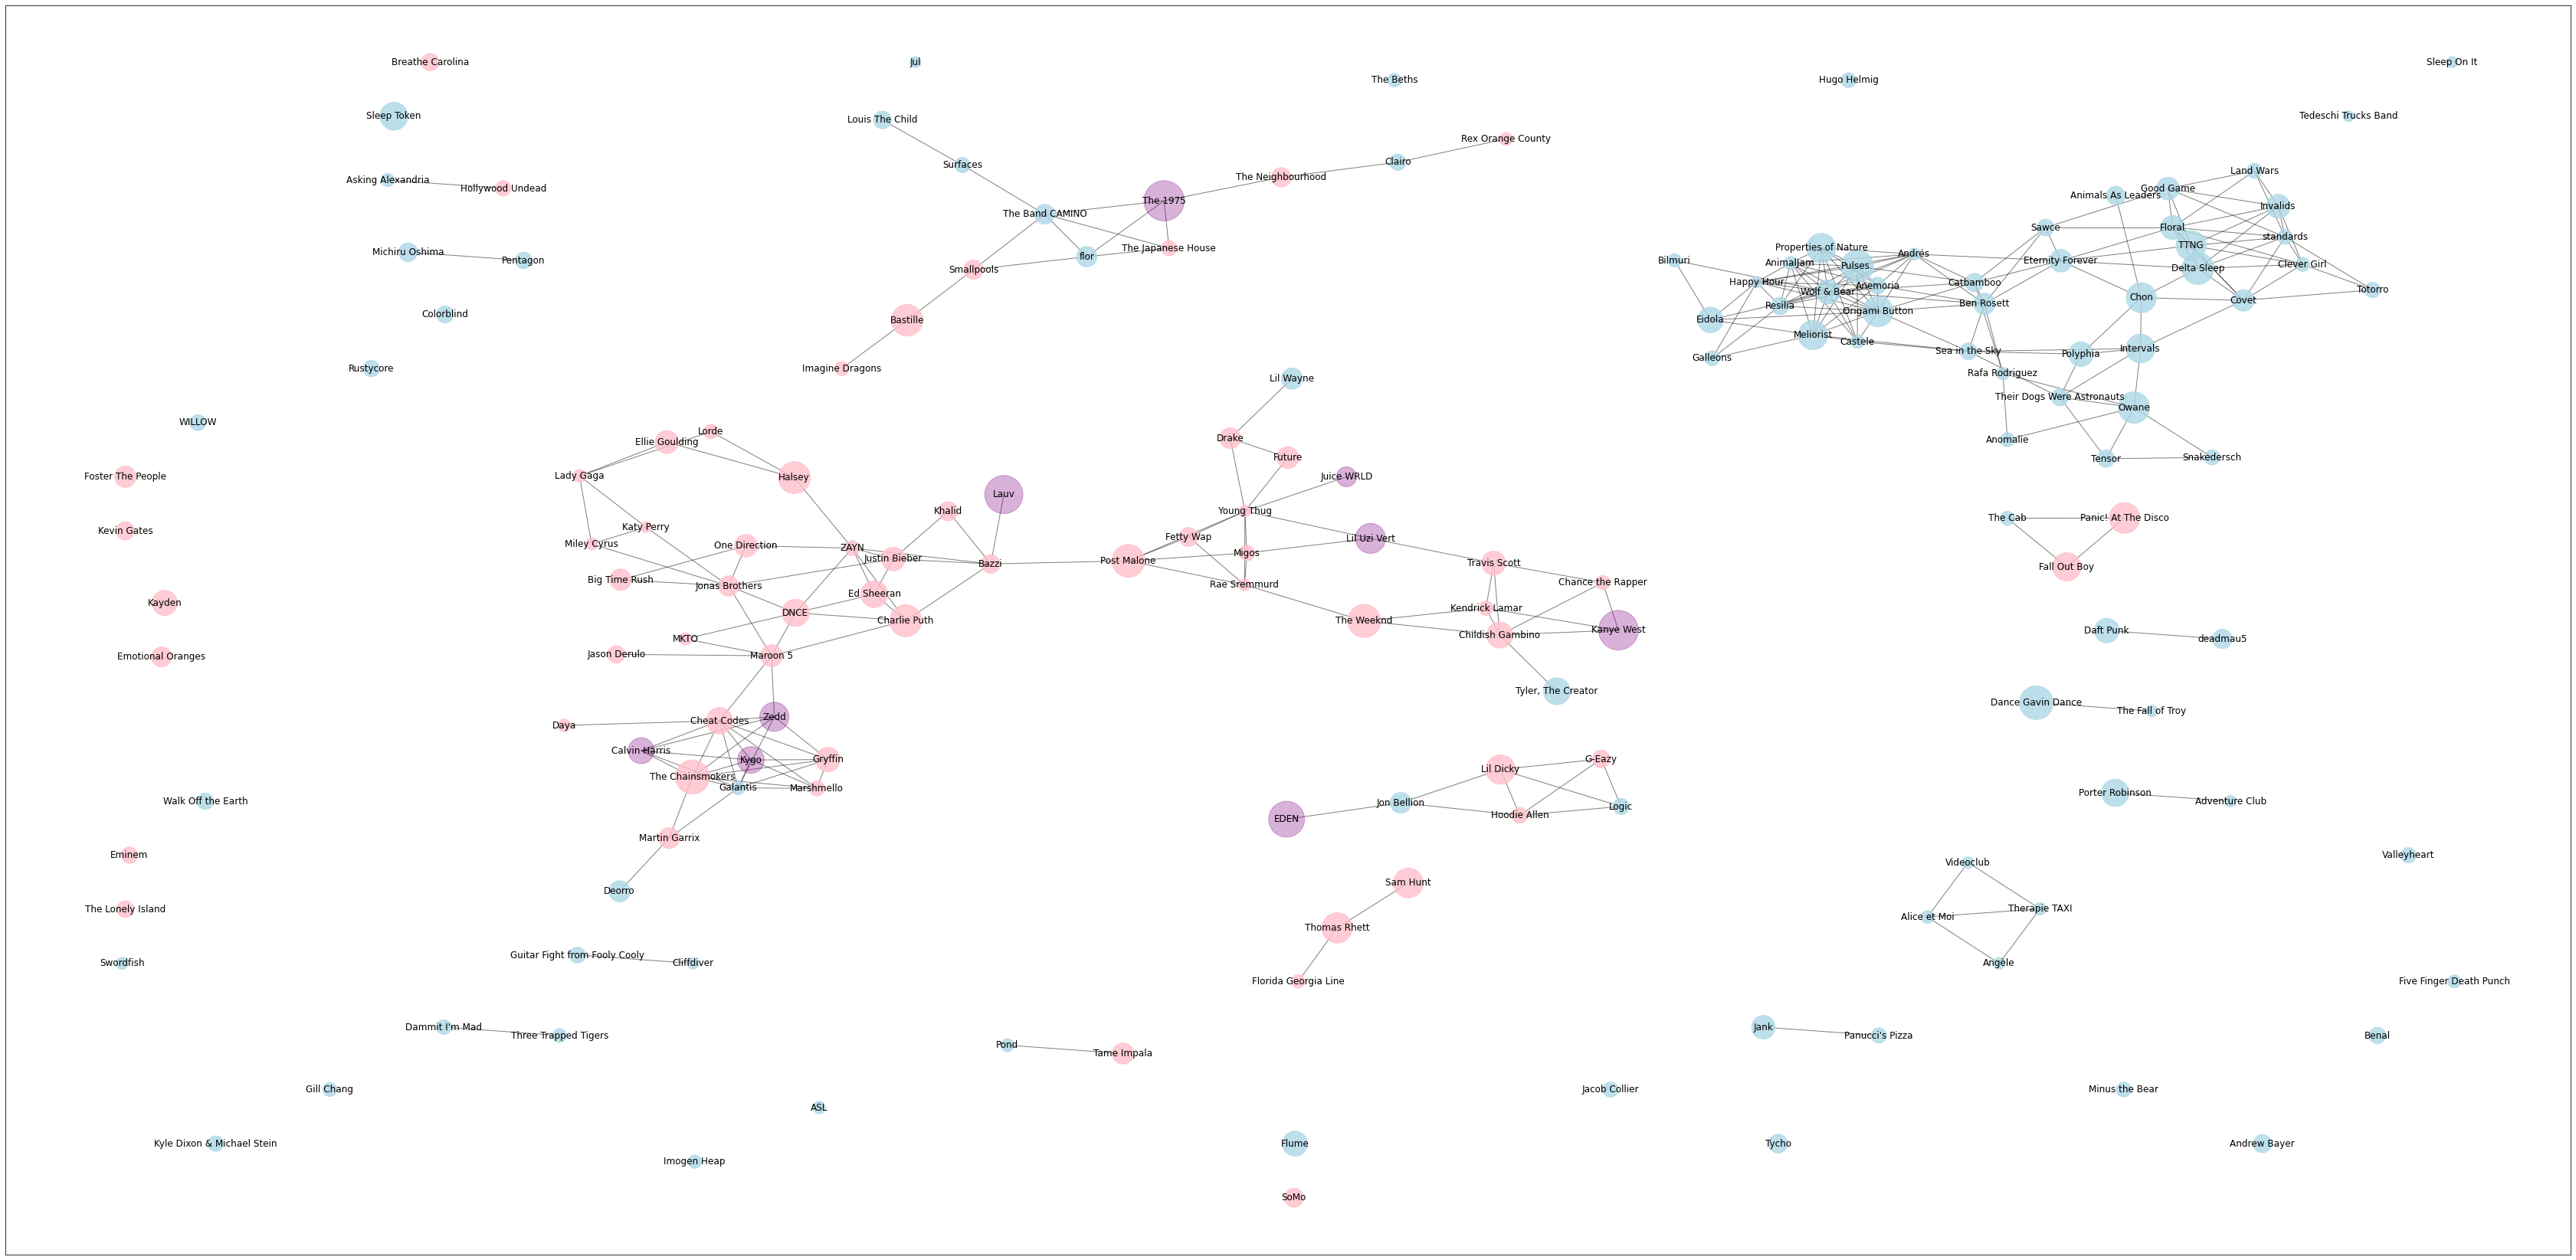

In [8]:
artist_map = []

for artist in common_artists_stripped + user_1_artists_unique_stripped + user_2_artists_unique_stripped:
  item = {'name': artist['name'],  'id': artist['id'], 'weight': artist['weight']}
  edges = []
  for similar_artist in artist['similar_artists']:
    for artist_2 in common_artists_stripped + user_1_artists_unique_stripped + user_2_artists_unique_stripped:
      # print(artist)
      # print(similar_artist)
      # print('----------------------------------------------')
      # print(f'{artist_id} ?= {sim_artist_id}')
      # print(artist['name'] + ' ?= ' + artist_2['name'] + '.' + similar_artist['name'])
      if artist_2['id'] == similar_artist['id']:
        edges.append({'name': artist_2['name'], 'id':artist_2['id'], 'weight': artist['weight']})
  item['edges'] = edges
  artist_map.append(item)

artist_map

import networkx as nx
G=nx.Graph()
G

for artist in artist_map:
  G.add_node(artist['id']) #change back to name

print(G.nodes())

print(len(G.nodes()))

for artist in artist_map:
  for edge in artist['edges']:
    graph_edge = (artist['id'], edge['id'])#change back to name
    G.add_edge(*graph_edge)

print(G.edges())
len(G.edges())

# nodes

user_1_node_list = []
user_2_node_list = []
common_node_list = []

user_1_node_sizes = []
user_2_node_sizes = []
common_node_sizes = []

user_1_node_dict = {}
user_2_node_dict = {}
common_node_dict = {}

for artist in user_1_artists_unique_stripped:
  user_1_node_list.append(artist['id'])#change back to name
  user_1_node_sizes.append(artist['weight'] * 2000)
  user_1_node_dict[artist['id']] = artist['name']

for artist in user_2_artists_unique_stripped:
  user_2_node_list.append(artist['id'])#change back to name
  user_2_node_sizes.append(artist['weight'] * 2000)
  user_2_node_dict[artist['id']] = artist['name']

for artist in common_artists_stripped:
  common_node_list.append(artist['id'])#change back to name
  common_node_sizes.append(artist['weight'] * 2000)
  common_node_dict[artist['id']] = artist['name']

# user_1_node_dict = {}
# user_2_node_dict = {}
# common_node_dict = {}

# for label in user_1_node_list:
#   user_1_node_dict[label] = label 

# for label in user_2_node_list:
#   user_2_node_dict[label] = label 

# for label in common_node_list:
#   common_node_dict[label] = label 

print(common_node_sizes)
print(common_node_list)
print(user_1_node_list)
print(user_2_node_list)


pos=nx.nx.nx_pydot.graphviz_layout(G)
#pos=nx.nx.nx_pydot.pydot_layout(G)

#pos = nx.drawing.layout.spring_layout(G)

plt.figure()

nx.draw_networkx_nodes(G,pos,
                       nodelist=common_node_list,
                       node_color='purple',
                       node_size = common_node_sizes,
                   alpha=0.3)
nx.draw_networkx_labels(G, pos, labels=common_node_dict)

nx.draw_networkx_nodes(G,pos,
                       nodelist=user_1_node_list,
                       node_color='lightblue',
                       node_size = user_1_node_sizes,
                   alpha=0.8)
nx.draw_networkx_labels(G, pos, labels=user_1_node_dict)

nx.draw_networkx_nodes(G,pos,
                       nodelist=user_2_node_list,
                       node_color='pink',
                       node_size = user_2_node_sizes,
                   alpha=0.8)
nx.draw_networkx_labels(G, pos, labels=user_2_node_dict)



nx.draw_networkx_edges(G,pos,alpha=0.5)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=user_2_node_list,
#                        node_color='r',
#                        with_labels = True,
#                    alpha=0.8)

# nx.draw_networkx_nodes(G,pos,
#                        nodelist=common_node_list,
#                        node_color='purple',
#                        with_labels = True,
#                    alpha=0.8)

# nx.draw_networkx_edges(G,pos,alpha=0.5)
# # nx.draw(G,pos = nx.nx_pydot.graphviz_layout(G), with_labels = True,node_color='lightblue', edge_color='gray')

# plt.rcParams["figure.figsize"] = (40,20)
# # plt.savefig("avery_medium_term.png") # save as png
# plt.show() # display

# nx.draw(G,pos = nx.nx_pydot.graphviz_layout(G), with_labels = True,node_color='lightblue', edge_color='gray')

plt.rcParams["figure.figsize"] = (60,30)
# plt.savefig("avery_medium_term.png") # save as png
plt.show() # display
